In [1]:
## System
import sys
import os
from collections import defaultdict
from collections import OrderedDict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## ML Classifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold


## Fig utils
from fig_utils import (ConSpliceML_train, 
                       ConSpliceML_score, 
                       get_pr_vars, 
                       plot_combined_pr_curve, 
                       enrichment_by_bin,
                       plot_conspliceml_enrichment)

In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
## Set random seed
random_seed = 156498

In [4]:
## Number of folds for cross validation
FOLDS = 5

In [5]:
## Testing split 
test_split = 0.4

In [6]:
## Decision trees
ntrees = 1000

In [7]:
## ConSplice score column
consplice_col = "50bp_ConSplice"

# Load variant sets

In [8]:
## Read in HGMD pathogenic set
patho_vars =  pd.read_csv("../data/hgmd.pathogenic.dm.splice_altering.txt", sep = "\t", index_col = False)
patho_vars = patho_vars.rename(columns = {"#chrom":"chrom"})

In [9]:
## Get relative positions
patho_vars["relative_pos"] = patho_vars.apply(lambda x: "{}{}{}".format("D" if x.type == "ds" else "A" if x.type == "as" else "Missing",
                                        "+" if int(x.location) >= 0 else "-",
                                        abs(int(x.location))), axis = 1)

patho_vars["relative_pos2"] = patho_vars.apply(lambda x: "{}{}{}".format("D" if x.type == "ds" else "A" if x.type == "as" else "Missing",
                                        "+" if int(x.location) >= 0 else "-",
                                        abs(int(x.location)) if abs(int(x.location)) < 11 else "Deep Intronic" if (x.type == "as" and int(x.location) < -10) or (x.type == "ds" and int(x.location) > 10) else "Deep Exonic" if (x.type == "ds" and int(x.location) < -10) or (x.type == "as" and int(x.location) > 10) else "MISSING"  ), axis = 1)

In [10]:
## Filter varaints

### Keep variants if they have CADD score, SpliceAI score, SQUIRLS score, and ConSplice score

patho_vars = patho_vars.loc[~(patho_vars[consplice_col].isna()) & ~(patho_vars.MAX_SpliceAI.isna()) & ~(patho_vars.CADD_PHRED.isna()) & ~(patho_vars.MAX_SQUIRLS.isna()) & ~(patho_vars.chrom.isna())  &(patho_vars.chrom != "X")]

In [11]:
benign_vars = pd.read_csv("../data/benign.combined.txt", sep = "\t", index_col = False)
benign_vars = benign_vars.rename(columns = {"#chrom":"chrom"})

In [12]:
## Set labels
patho_vars["patho_label"] = 1
benign_vars["patho_label"] = 0

In [13]:
## Combine patho and benign sets
raw_combined_df = pd.concat([patho_vars,benign_vars])

# Split data into training and test sets

In [14]:
## Shuffle df
raw_combined_df = raw_combined_df.sample(frac=1, random_state = random_seed)

In [15]:
## Train test split
combined_df, test_df, y_train, y_test = train_test_split(raw_combined_df, 
                                                         raw_combined_df["patho_label"], 
                                                         test_size = test_split, 
                                                         random_state = random_seed,
                                                         shuffle = True)



In [16]:
print("Raw Number of pathogenic variants: {}".format(raw_combined_df.loc[raw_combined_df.patho_label == 1].shape[0]))
print("Raw Number of benign variants: {}".format(raw_combined_df.loc[raw_combined_df.patho_label == 0].shape[0]))
print("Number of pathogenic training variants: {}".format(combined_df.loc[combined_df.patho_label == 1].shape[0]))
print("Number of benign training variants: {}".format(combined_df.loc[combined_df.patho_label == 0].shape[0]))
print("Number of pathogenic test variants: {}".format(test_df.loc[test_df.patho_label == 1].shape[0]))
print("Number of benign test variants: {}".format(test_df.loc[test_df.patho_label == 0].shape[0]))

Raw Number of pathogenic variants: 18317
Raw Number of benign variants: 48978
Number of pathogenic training variants: 10990
Number of benign training variants: 29387
Number of pathogenic test variants: 7327
Number of benign test variants: 19591


# Stratified K-Fold cross-validation 

In [17]:
# Set up Stratified K Fold
cv = StratifiedKFold(n_splits=FOLDS, random_state = random_seed)

/Users/michaelcormier/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [18]:
## Get train test split index for the K-fold cross validation 

train_index_list = []
test_index_list = []
for train_index, test_index in cv.split(combined_df[consplice_col], combined_df["patho_label"]):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

## Train the ConSpliceML model and scoring test sets

In [19]:
## Perform K-fold cross validation 

by_fold_scored_df = pd.DataFrame(columns = combined_df.columns)

ConSpliceML_features = [consplice_col,"MAX_SpliceAI","MAX_SQUIRLS"]

## iterate through each fold
for i in range(FOLDS):
    
    ## Train  
    rf = ConSpliceML_train(training_df = combined_df.iloc[train_index_list[i]],
                            feature_col_names = ConSpliceML_features,
                            label_col = "patho_label",
                            n_estimators = ntrees,
                            random_state = random_seed)

    
    ## Score   
    scored_test_combined_df = ConSpliceML_score(rf,
                                                var_df = combined_df.iloc[test_index_list[i]],
                                                feature_col_names = ConSpliceML_features,
                                                new_col_name = "ConSpliceML",
                                                sort_by_cols = ["chrom","pos"])
    
    ## Add fold label
    scored_test_combined_df["fold_label"] = np.repeat(i,scored_test_combined_df.shape[0])
    
    by_fold_scored_df = pd.concat([by_fold_scored_df,scored_test_combined_df])

In [20]:
## Train full RF and test hold out set
ConSpliceML_features = [consplice_col,"MAX_SpliceAI","MAX_SQUIRLS"]

full_rf = ConSpliceML_train(training_df = combined_df,
                            feature_col_names = ConSpliceML_features,
                            label_col = "patho_label",
                            n_estimators = ntrees,
                            random_state = random_seed)

scored_test_df = ConSpliceML_score(full_rf,
                                   var_df = test_df,
                                   feature_col_names = ConSpliceML_features,
                                   new_col_name = "ConSpliceML",
                                   sort_by_cols = ["chrom","pos"])

In [21]:
score_dict = OrderedDict({"CADD":{"col": "CADD_PHRED","label":"CADD", "color": sns.color_palette("colorblind")[0]},
                         "MAX_SpliceAI":{"col": "MAX_SpliceAI","label":"SpliceAI",  "color": sns.color_palette("colorblind")[1]},
                         "MAX_SQUIRLS":{"col": "MAX_SQUIRLS","label":"SQUIRLS",  "color": sns.color_palette("colorblind")[2]},
                         "ConSpliceML":{"col": "ConSpliceML","label":"ConSpliceML",  "color": "black"},
                         })

# All variant in the truth set

In [22]:
## Get the patho and benign set
patho_test_set = by_fold_scored_df.loc[by_fold_scored_df.patho_label == 1]
benign_test_set = by_fold_scored_df.loc[by_fold_scored_df.patho_label == 0]

In [23]:
scored_combined_df = pd.concat([patho_test_set,benign_test_set])

PR AUC=0.966, Avg. Precision Score=0.964
PR AUC=0.968, Avg. Precision Score=0.966
PR AUC=0.969, Avg. Precision Score=0.967
PR AUC=0.970, Avg. Precision Score=0.967
PR AUC=0.970, Avg. Precision Score=0.968
PR AUC=0.968, Avg. Precision Score=0.966


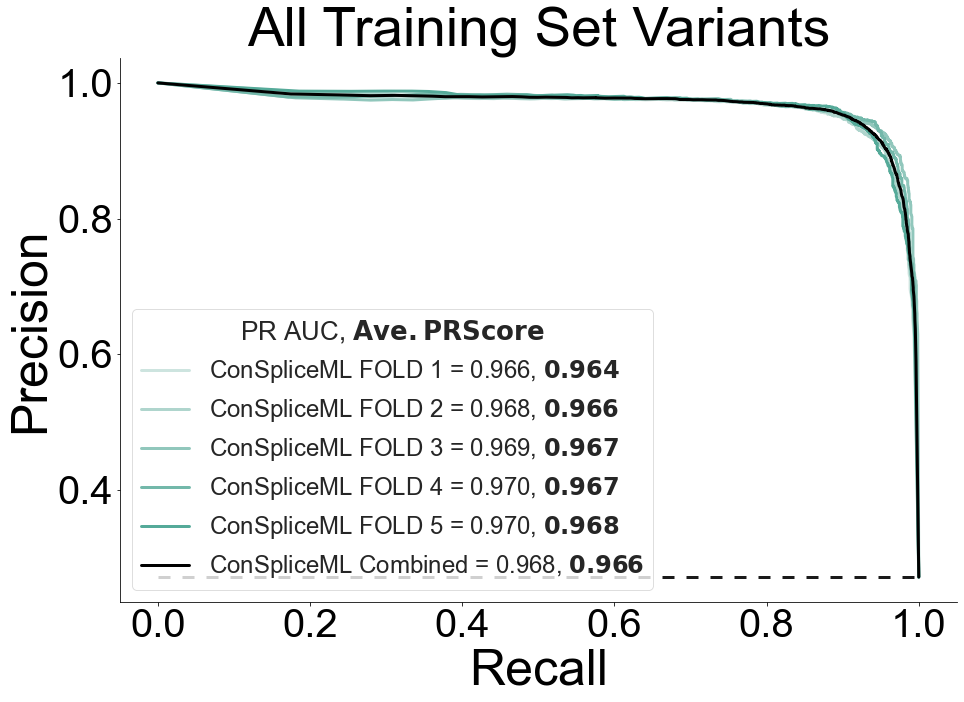

In [24]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df =  pd.concat([patho_test_set.loc[patho_test_set["fold_label"] == i],
                                   benign_test_set.loc[benign_test_set["fold_label"] == i]])
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(scored_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (patho_test_set.shape[0] / (patho_test_set.shape[0] + benign_test_set.shape[0] ))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "All Training Set Variants"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")



plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure13_A.svg')



In [25]:
print("C.V. Number of pathogenic variants = {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 10990
C.V. Number of benign variants =     29387


PR AUC=0.933, Avg. Precision Score=0.944
PR AUC=0.967, Avg. Precision Score=0.962
PR AUC=0.939, Avg. Precision Score=0.939
PR AUC=0.977, Avg. Precision Score=0.976


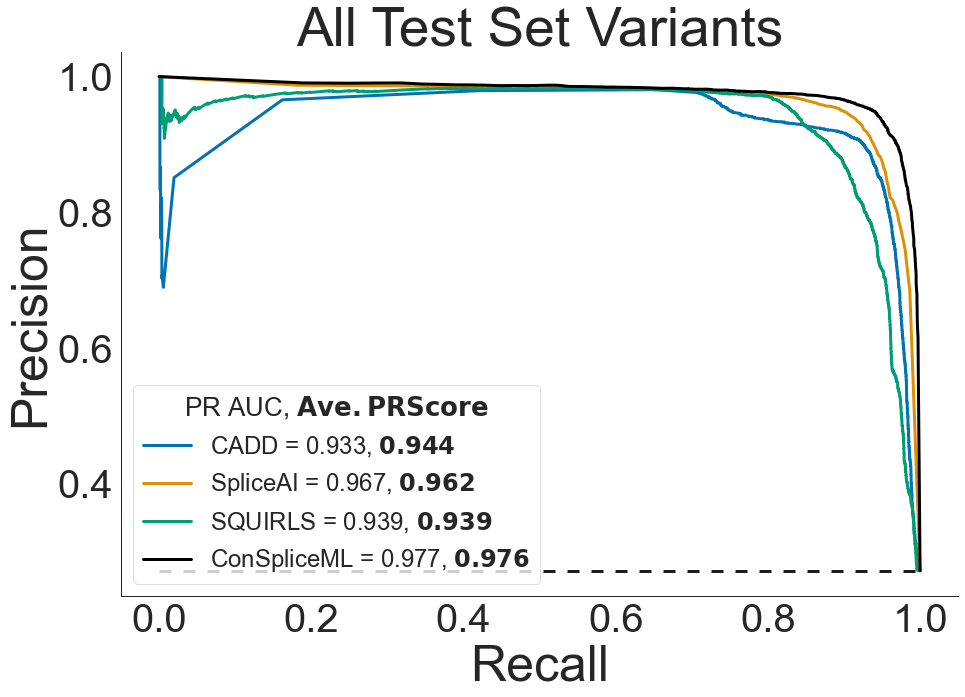

In [26]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(scored_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label": info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] / (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] + scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "All Test Set Variants"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure14.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.001337  0.0-0.1  0.098266    0.001103    0.001621
1    0.319511  0.1-0.2  0.136854    0.244339    0.417809
2    0.601799  0.2-0.3  0.139651    0.457696    0.791270
3    1.202789  0.3-0.4  0.134049    0.924879    1.564207
4    1.412474  0.4-0.5  0.155679    1.041032    1.916446
5    2.186465  0.5-0.6  0.148872    1.633129    2.927282
6    5.818458  0.6-0.7  0.148073    4.352768    7.777684
7    7.702201  0.7-0.8  0.133014    5.934591    9.996292
8   24.784225  0.8-0.9  0.132311   19.122740   32.121851
9  569.464442  0.9-1.0  0.087893  479.348074  676.522487


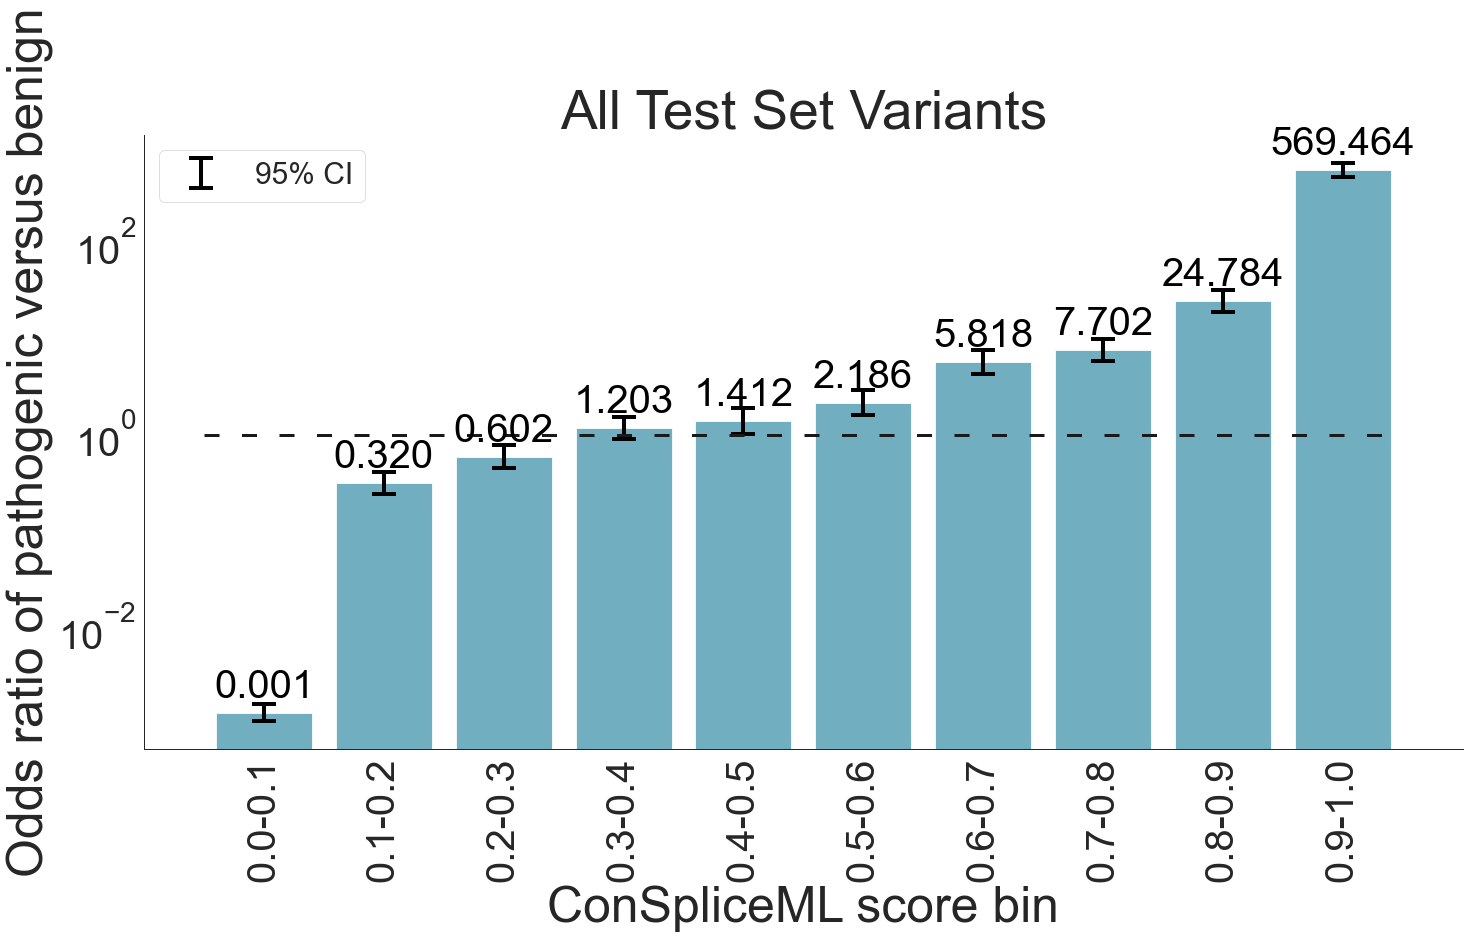

In [27]:
enrichment_df = enrichment_by_bin(scored_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "All Test Set Variants",
                            plot_value_offset = 2.25)

plt.savefig('../figures/figure5_E.svg')

In [28]:
print("TEST: Number of pathogenic variants = {}".format(scored_test_df.loc[scored_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 7327
TEST: Number of benign variants =     19591


In [29]:
non_canonical_combined_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A-1") & (patho_test_set.relative_pos != "A-2") & (patho_test_set.relative_pos != "D+1") & (patho_test_set.relative_pos != "D+2")],benign_test_set.loc[(benign_test_set.relative_pos != "A-1") & (benign_test_set.relative_pos != "A-2") & (benign_test_set.relative_pos != "D+1") & (benign_test_set.relative_pos != "D+2")]])
non_canonical_test_df = scored_test_df.loc[(scored_test_df.relative_pos != "A-1") & (scored_test_df.relative_pos != "A-2") & (scored_test_df.relative_pos != "D+1") & (scored_test_df.relative_pos != "D+2")]


PR AUC=0.856, Avg. Precision Score=0.853
PR AUC=0.871, Avg. Precision Score=0.870
PR AUC=0.892, Avg. Precision Score=0.890
PR AUC=0.873, Avg. Precision Score=0.871
PR AUC=0.862, Avg. Precision Score=0.859
PR AUC=0.870, Avg. Precision Score=0.868


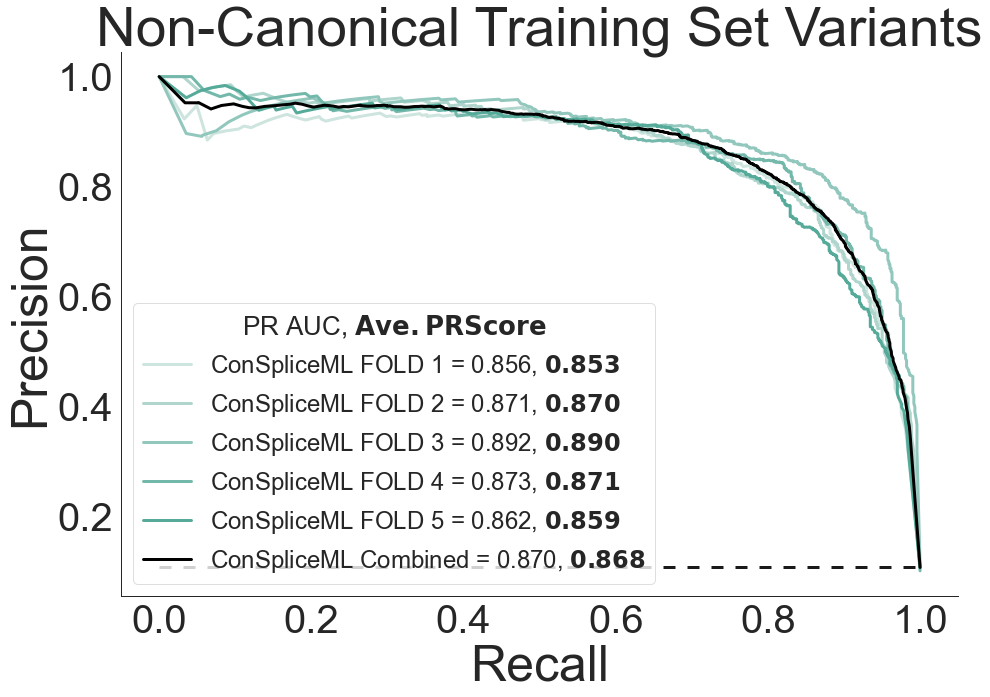

In [30]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df = non_canonical_combined_df.loc[non_canonical_combined_df["fold_label"] == i]
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(non_canonical_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
               + 
               non_canonical_combined_df[non_canonical_combined_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Non-Canonical Training Set Variants"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")


plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure13_B.svg')


In [31]:
print("C.V. Number of pathogenic variants = {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 3525
C.V. Number of benign variants =     29234


PR AUC=0.642, Avg. Precision Score=0.644
PR AUC=0.819, Avg. Precision Score=0.809
PR AUC=0.784, Avg. Precision Score=0.784
PR AUC=0.884, Avg. Precision Score=0.883


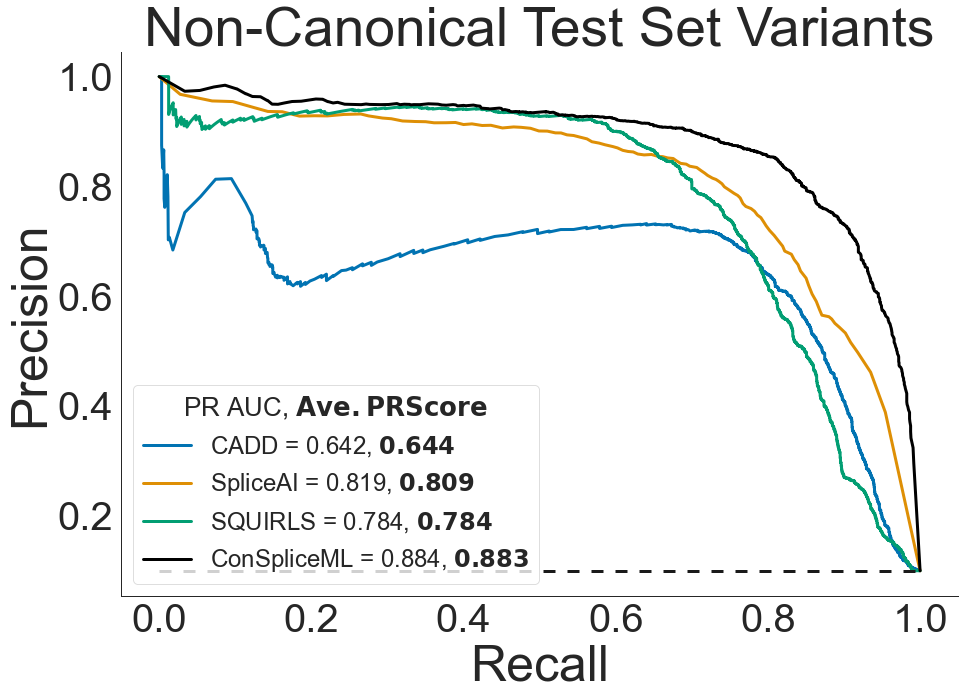

In [32]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_canonical_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
               + 
               non_canonical_test_df[non_canonical_test_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Non-Canonical Test Set Variants"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_A.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.004421  0.0-0.1  0.100572    0.003630    0.005384
1    1.046512  0.1-0.2  0.141206    0.793500    1.380198
2    1.999246  0.2-0.3  0.142658    1.511588    2.644229
3    3.859557  0.3-0.4  0.138975    2.939269    5.067989
4    4.612680  0.4-0.5  0.160533    3.367482    6.318316
5    6.797067  0.5-0.6  0.154284    5.023339    9.197096
6   17.379024  0.6-0.7  0.153140   12.872715   23.462842
7   20.547865  0.7-0.8  0.144267   15.486891   27.262718
8   47.940959  0.8-0.9  0.146044   36.007412   63.829512
9  256.772259  0.9-1.0  0.113835  205.423176  320.956936


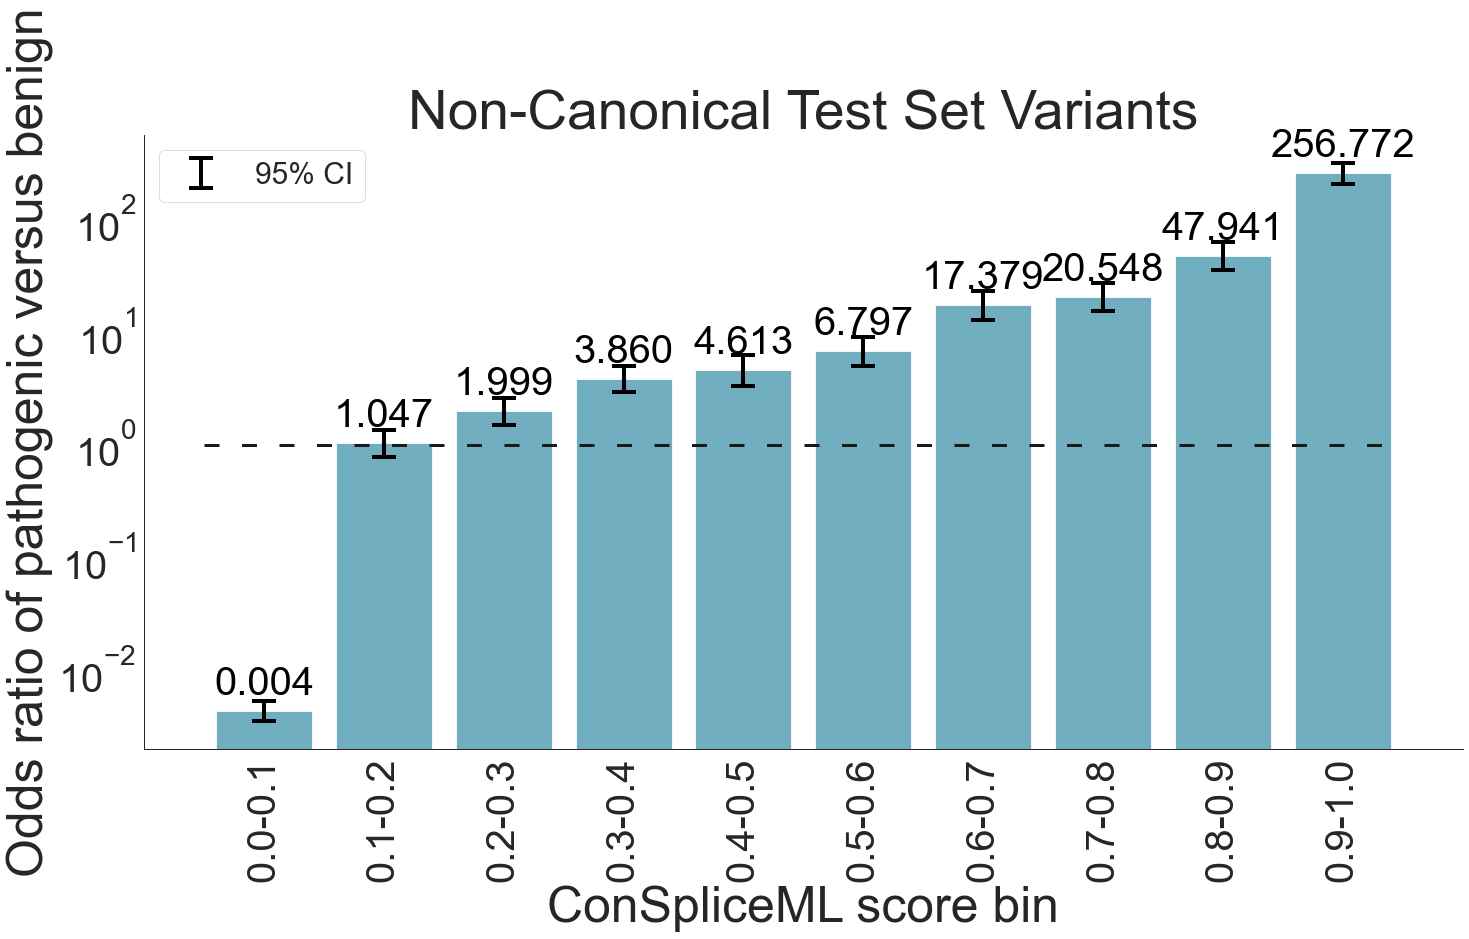

In [33]:
enrichment_df = enrichment_by_bin(non_canonical_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Non-Canonical Test Set Variants",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure15_A.svg')

In [34]:
print("TEST: Number of pathogenic variants = {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 2170
TEST: Number of benign variants =     19515


In [35]:
non_splice_region_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A+3") &
                                                     (patho_test_set.relative_pos != "A+2") & 
                                                     (patho_test_set.relative_pos != "A+1") & 
                                                     (patho_test_set.relative_pos != "A-1") & 
                                                     (patho_test_set.relative_pos != "A-2") & 
                                                     (patho_test_set.relative_pos != "A-3") &
                                                     (patho_test_set.relative_pos != "A-4") & 
                                                     (patho_test_set.relative_pos != "A-5") & 
                                                     (patho_test_set.relative_pos != "A-6") & 
                                                     (patho_test_set.relative_pos != "A-7") & 
                                                     (patho_test_set.relative_pos != "A-8") &
                                                     (patho_test_set.relative_pos != "D-3") & 
                                                     (patho_test_set.relative_pos != "D-2") & 
                                                     (patho_test_set.relative_pos != "D-1") & 
                                                     (patho_test_set.relative_pos != "D+1") & 
                                                     (patho_test_set.relative_pos != "D+2") & 
                                                     (patho_test_set.relative_pos != "D+3") & 
                                                     (patho_test_set.relative_pos != "D+4") & 
                                                     (patho_test_set.relative_pos != "D+5") & 
                                                     (patho_test_set.relative_pos != "D+6") & 
                                                     (patho_test_set.relative_pos != "D+7") & 
                                                     (patho_test_set.relative_pos != "D+8")],
                                 benign_test_set.loc[(benign_test_set.relative_pos != "A+3") &
                                                     (benign_test_set.relative_pos != "A+2") & 
                                                     (benign_test_set.relative_pos != "A+1") & 
                                                     (benign_test_set.relative_pos != "A-1") & 
                                                     (benign_test_set.relative_pos != "A-2") & 
                                                     (benign_test_set.relative_pos != "A-3") &
                                                     (benign_test_set.relative_pos != "A-4") & 
                                                     (benign_test_set.relative_pos != "A-5") & 
                                                     (benign_test_set.relative_pos != "A-6") & 
                                                     (benign_test_set.relative_pos != "A-7") & 
                                                     (benign_test_set.relative_pos != "A-8") &
                                                     (benign_test_set.relative_pos != "D-3") & 
                                                     (benign_test_set.relative_pos != "D-2") & 
                                                     (benign_test_set.relative_pos != "D-1") & 
                                                     (benign_test_set.relative_pos != "D+1") & 
                                                     (benign_test_set.relative_pos != "D+2") & 
                                                     (benign_test_set.relative_pos != "D+3") & 
                                                     (benign_test_set.relative_pos != "D+4") & 
                                                     (benign_test_set.relative_pos != "D+5") & 
                                                     (benign_test_set.relative_pos != "D+6") & 
                                                     (benign_test_set.relative_pos != "D+7") & 
                                                     (benign_test_set.relative_pos != "D+8")]])


non_splice_region_test_df = test_df.loc[(test_df.relative_pos != "A+3") &
                                        (test_df.relative_pos != "A+2") & 
                                        (test_df.relative_pos != "A+1") & 
                                        (test_df.relative_pos != "A-1") & 
                                        (test_df.relative_pos != "A-2") & 
                                        (test_df.relative_pos != "A-3") &
                                        (test_df.relative_pos != "A-4") & 
                                        (test_df.relative_pos != "A-5") & 
                                        (test_df.relative_pos != "A-6") & 
                                        (test_df.relative_pos != "A-7") & 
                                        (test_df.relative_pos != "A-8") &
                                        (test_df.relative_pos != "D-3") & 
                                        (test_df.relative_pos != "D-2") & 
                                        (test_df.relative_pos != "D-1") & 
                                        (test_df.relative_pos != "D+1") & 
                                        (test_df.relative_pos != "D+2") & 
                                        (test_df.relative_pos != "D+3") & 
                                        (test_df.relative_pos != "D+4") & 
                                        (test_df.relative_pos != "D+5") & 
                                        (test_df.relative_pos != "D+6") & 
                                        (test_df.relative_pos != "D+7") & 
                                        (test_df.relative_pos != "D+8")]

PR AUC=0.596, Avg. Precision Score=0.592
PR AUC=0.592, Avg. Precision Score=0.591
PR AUC=0.704, Avg. Precision Score=0.700
PR AUC=0.657, Avg. Precision Score=0.655
PR AUC=0.593, Avg. Precision Score=0.591
PR AUC=0.627, Avg. Precision Score=0.624


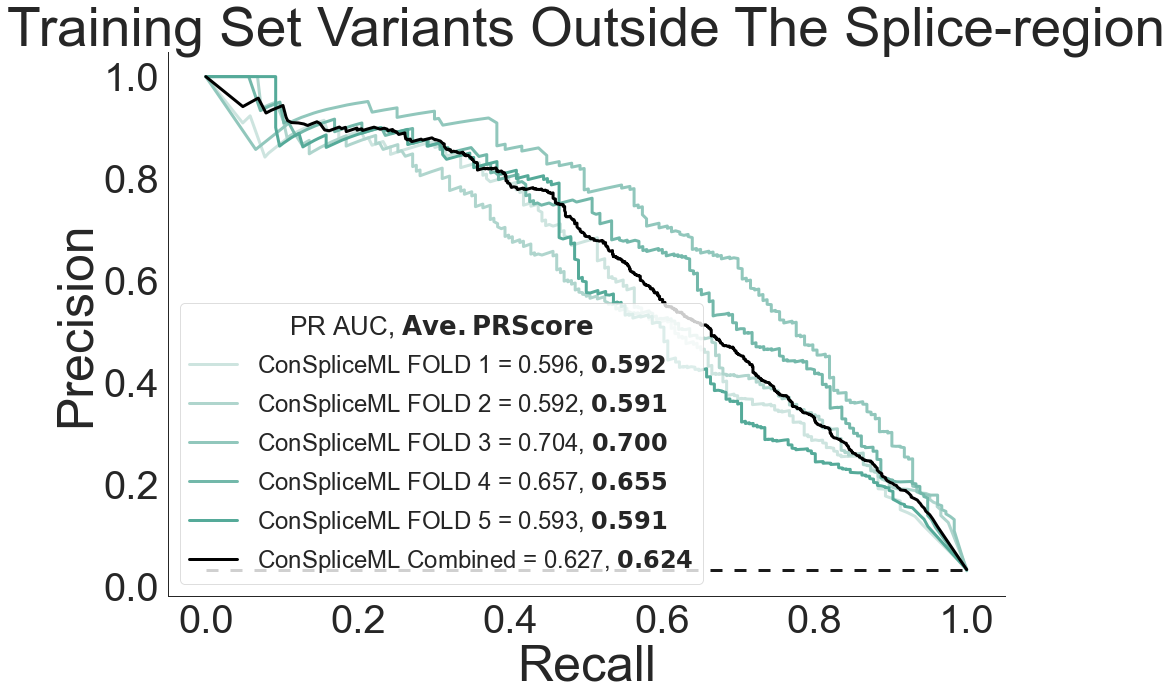

In [36]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df = non_splice_region_df.loc[non_splice_region_df["fold_label"] == i]
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(non_splice_region_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (non_splice_region_df[non_splice_region_df.patho_label == 1].shape[0] 
              / 
              (non_splice_region_df[non_splice_region_df.patho_label == 1].shape[0] 
               + 
               non_splice_region_df[non_splice_region_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Training Set Variants Outside The Splice-region"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure13_C.svg')


In [37]:
print("C.V. Number of pathogenic variants = {}".format(non_splice_region_df.loc[non_splice_region_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(non_splice_region_df.loc[non_splice_region_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 986
C.V. Number of benign variants =     28894


PR AUC=0.207, Avg. Precision Score=0.209
PR AUC=0.646, Avg. Precision Score=0.635
PR AUC=0.477, Avg. Precision Score=0.477
PR AUC=0.682, Avg. Precision Score=0.681


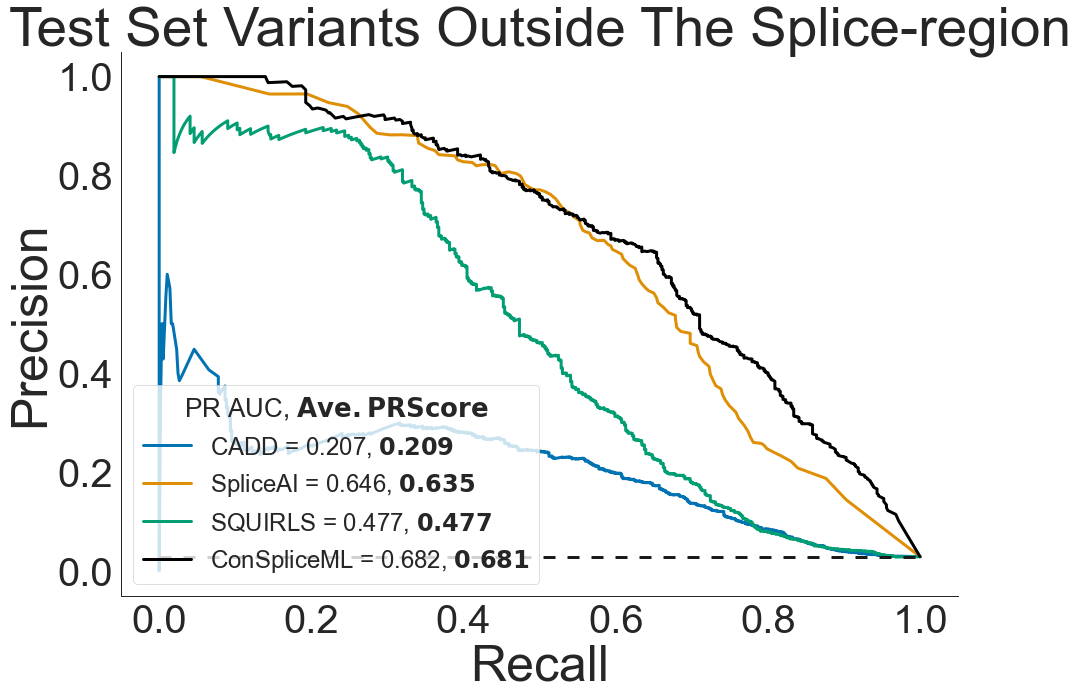

In [38]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_splice_region_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_splice_region_test_df[non_splice_region_test_df.patho_label == 1].shape[0] 
              / 
              (non_splice_region_test_df[non_splice_region_test_df.patho_label == 1].shape[0] 
               + 
               non_splice_region_test_df[non_splice_region_test_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Test Set Variants Outside The Splice-region"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_B.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.011556  0.0-0.1  0.124374    0.009056    0.014746
1    1.961095  0.1-0.2  0.204364    1.313835    2.927228
2    4.104955  0.2-0.3  0.196210    2.794415    6.030119
3    6.541421  0.3-0.4  0.205040    4.376614    9.777010
4    6.693611  0.4-0.5  0.244877    4.142065   10.816929
5    9.488947  0.5-0.6  0.236376    5.970496   15.080843
6   27.972972  0.6-0.7  0.216059   18.315770   42.722046
7   28.797878  0.7-0.8  0.207289   19.182823   43.232311
8   46.926324  0.8-0.9  0.206148   31.328526   70.289928
9  314.764472  0.9-1.0  0.181013  220.752036  448.814312


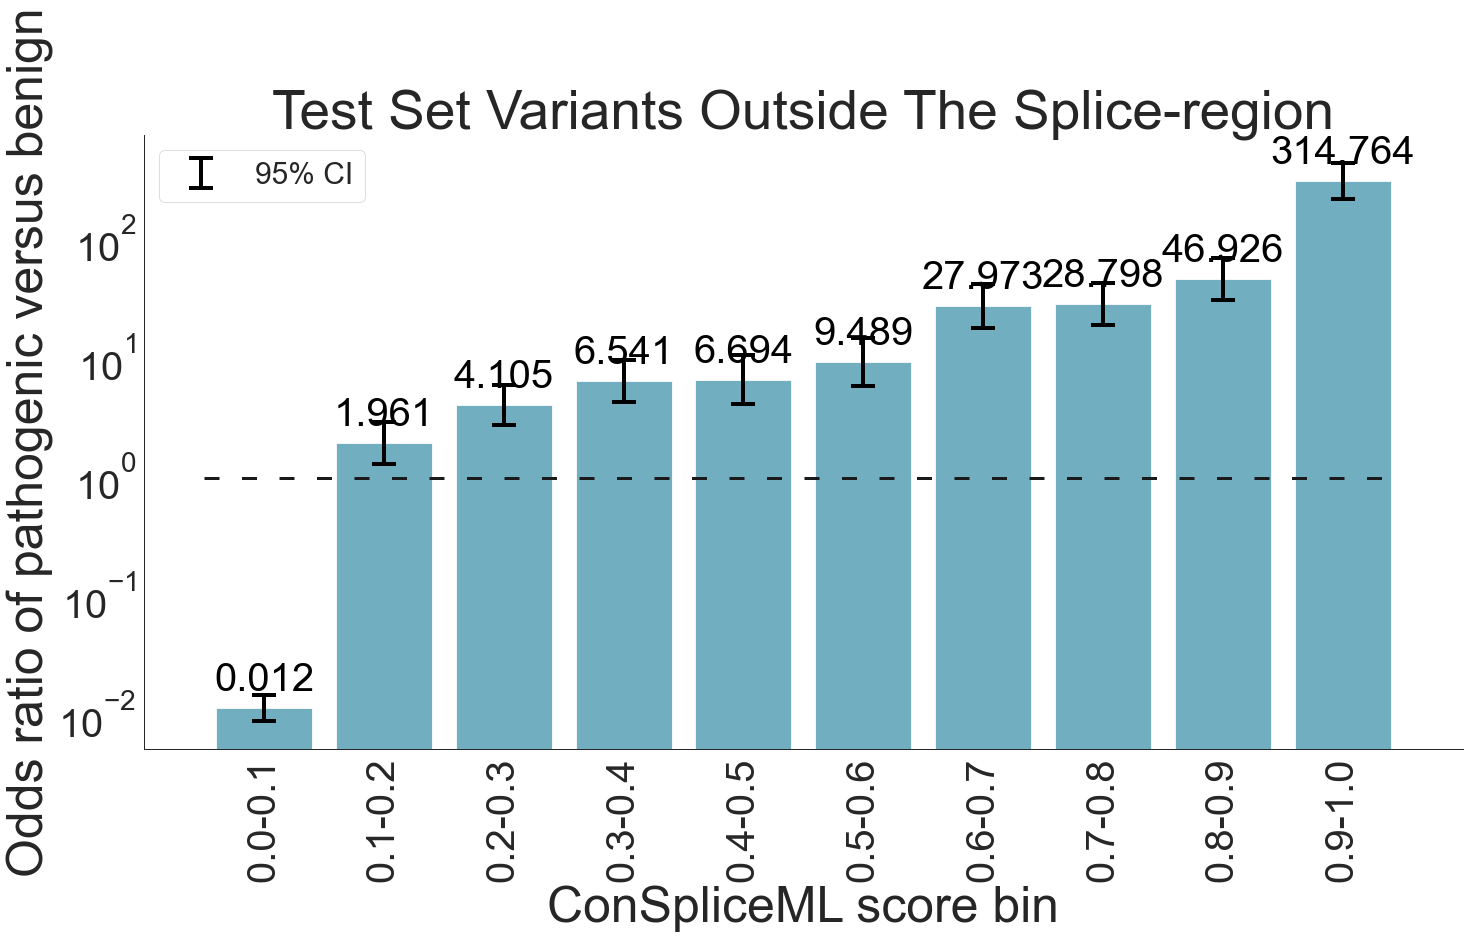

In [39]:
enrichment_df = enrichment_by_bin(non_splice_region_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Test Set Variants Outside The Splice-region",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure15_B.svg')

In [40]:
print("Number of pathogenic variants = {}".format(non_splice_region_test_df.loc[non_splice_region_test_df.patho_label == 1].shape[0]))
print("Number of benign variants =     {}".format(non_splice_region_test_df.loc[non_splice_region_test_df.patho_label == 0].shape[0]))

Number of pathogenic variants = 566
Number of benign variants =     19289


# Variants in the truth set with a SpliceAI score between 0.0 and 0.2

In [41]:
## Get the patho and benign set
patho_test_set = by_fold_scored_df.loc[(by_fold_scored_df.patho_label == 1) & 
                                        (by_fold_scored_df.MAX_SpliceAI >= 0.0) &
                                        (by_fold_scored_df.MAX_SpliceAI < 0.2)]
benign_test_set = by_fold_scored_df.loc[(by_fold_scored_df.patho_label == 0) & 
                                        (by_fold_scored_df.MAX_SpliceAI >= 0.0) &
                                        (by_fold_scored_df.MAX_SpliceAI < 0.2)]

scored_test_df = scored_test_df.loc[(scored_test_df.MAX_SpliceAI >= 0.0) & (scored_test_df.MAX_SpliceAI < 0.2)]

In [42]:
scored_combined_df = pd.concat([patho_test_set,benign_test_set])

PR AUC=0.564, Avg. Precision Score=0.562
PR AUC=0.593, Avg. Precision Score=0.592
PR AUC=0.627, Avg. Precision Score=0.627
PR AUC=0.542, Avg. Precision Score=0.542
PR AUC=0.502, Avg. Precision Score=0.500
PR AUC=0.563, Avg. Precision Score=0.560


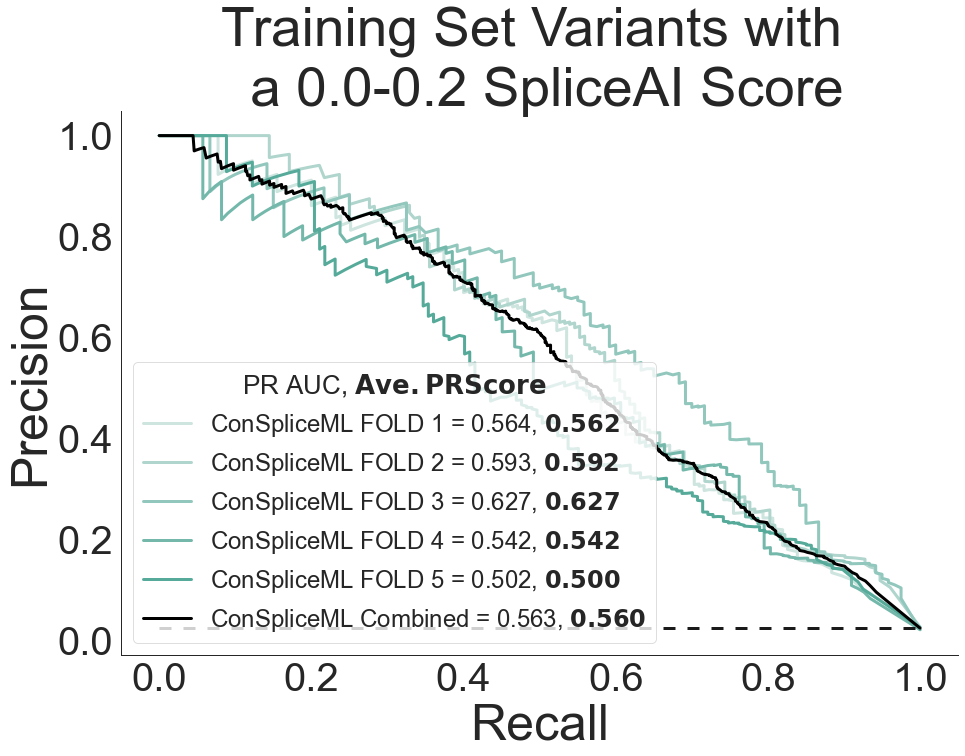

In [43]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df =  pd.concat([patho_test_set.loc[patho_test_set["fold_label"] == i],
                                   benign_test_set.loc[benign_test_set["fold_label"] == i]])
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(scored_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (patho_test_set.shape[0] / (patho_test_set.shape[0] + benign_test_set.shape[0] ))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Training Set Variants with \n a 0.0-0.2 SpliceAI Score"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure13_D.svg')


In [44]:
print("C.V. Number of pathogenic variants = {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(scored_combined_df.loc[scored_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 696
C.V. Number of benign variants =     28014


PR AUC=0.173, Avg. Precision Score=0.176
PR AUC=0.182, Avg. Precision Score=0.149
PR AUC=0.362, Avg. Precision Score=0.364
PR AUC=0.544, Avg. Precision Score=0.542


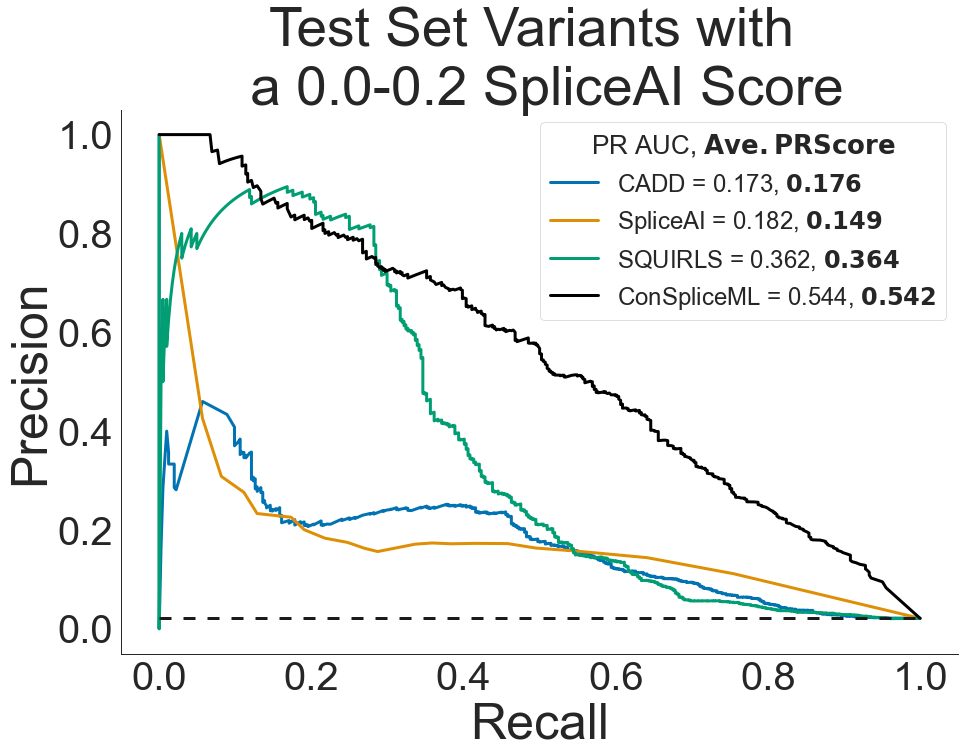

In [45]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(scored_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label": info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] / (scored_test_df.loc[scored_test_df.patho_label == 1].shape[0] + scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Test Set Variants with \n a 0.0-0.2 SpliceAI Score"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "upper right")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_C.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.014538  0.0-0.1  0.120658    0.011476    0.018416
1    5.214325  0.1-0.2  0.175334    3.697861    7.352680
2   10.486605  0.2-0.3  0.194467    7.163099   15.352140
3   15.968676  0.3-0.4  0.218046   10.415119   24.483505
4   27.344676  0.4-0.5  0.231363   17.375315   43.034113
5   31.221837  0.5-0.6  0.281111   17.995824   54.168298
6   72.387025  0.6-0.7  0.279199   41.879564  125.117856
7   63.253812  0.7-0.8  0.292537   35.651209  112.227461
8  118.885402  0.8-0.9  0.298935   66.171335  213.593074
9  387.330956  0.9-1.0  0.393178  179.226721  837.069766


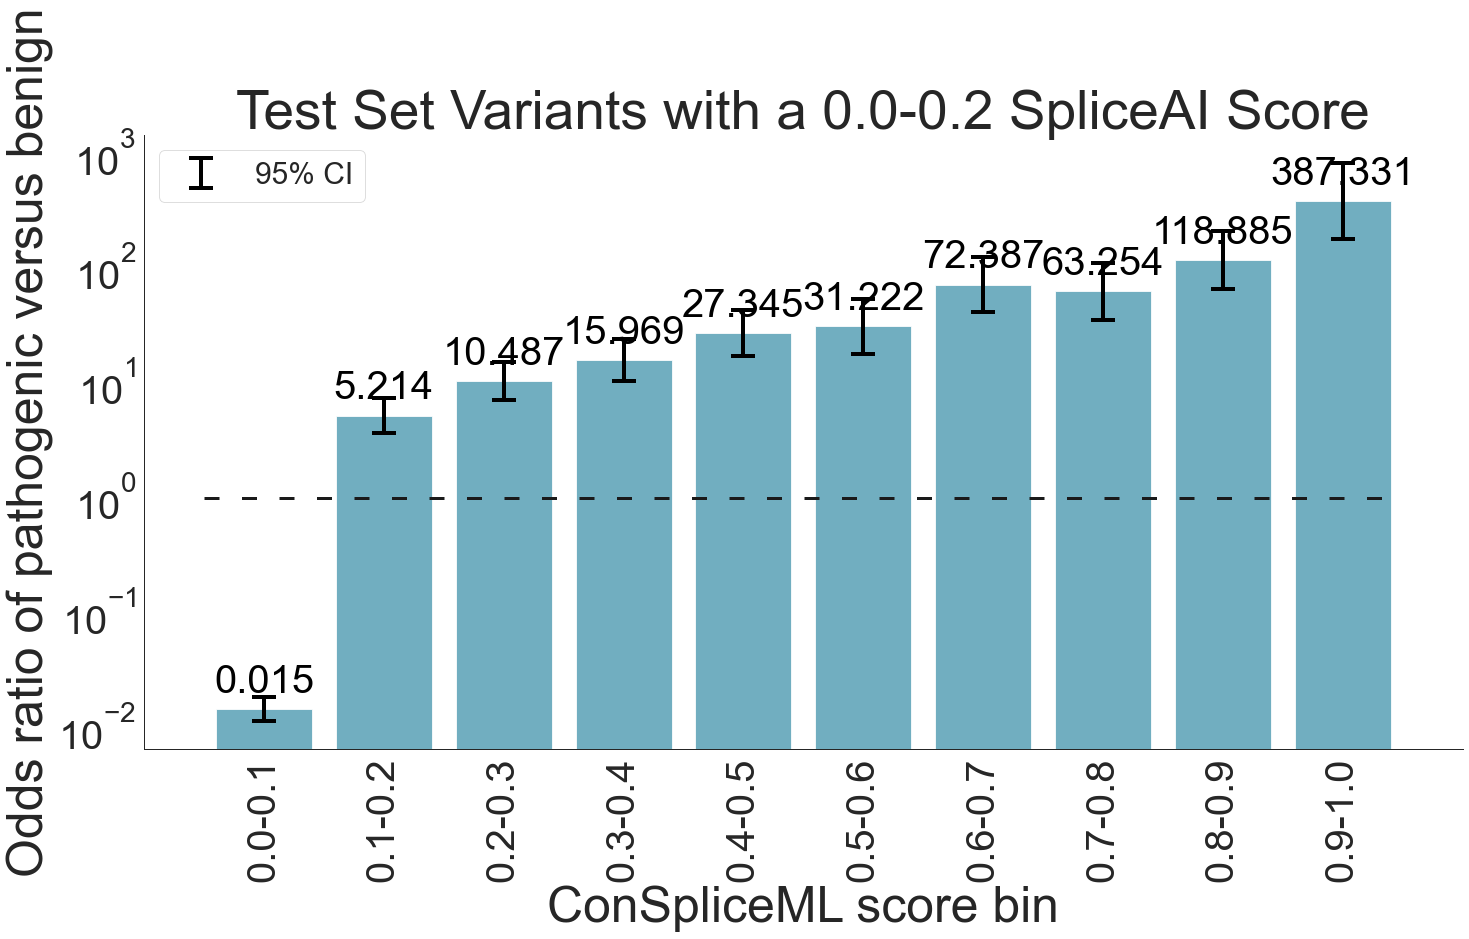

In [46]:
enrichment_df = enrichment_by_bin(scored_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Test Set Variants with a 0.0-0.2 SpliceAI Score",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure15_C.svg')

In [47]:
print("TEST: Number of pathogenic variants = {}".format(scored_test_df.loc[scored_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(scored_test_df.loc[scored_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 404
TEST: Number of benign variants =     18689


In [48]:
non_canonical_combined_df = pd.concat([patho_test_set.loc[(patho_test_set.relative_pos != "A-1") & (patho_test_set.relative_pos != "A-2") & (patho_test_set.relative_pos != "D+1") & (patho_test_set.relative_pos != "D+2")],benign_test_set.loc[(benign_test_set.relative_pos != "A-1") & (benign_test_set.relative_pos != "A-2") & (benign_test_set.relative_pos != "D+1") & (benign_test_set.relative_pos != "D+2")]])
non_canonical_test_df = scored_test_df.loc[(scored_test_df.relative_pos != "A-1") & (scored_test_df.relative_pos != "A-2") & (scored_test_df.relative_pos != "D+1") & (scored_test_df.relative_pos != "D+2")]


PR AUC=0.538, Avg. Precision Score=0.536
PR AUC=0.558, Avg. Precision Score=0.557
PR AUC=0.611, Avg. Precision Score=0.612
PR AUC=0.533, Avg. Precision Score=0.532
PR AUC=0.494, Avg. Precision Score=0.492
PR AUC=0.542, Avg. Precision Score=0.540


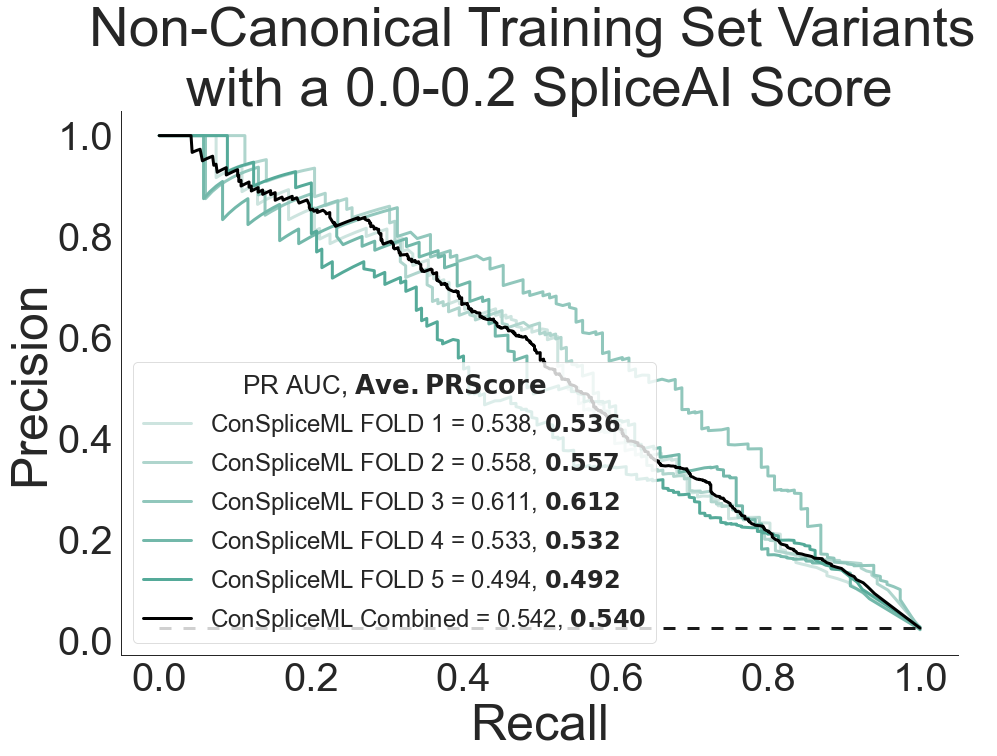

In [49]:
PR_LIST = []

pr_index = 1
for i in range(FOLDS):
    
    ## By Fold 
    fold_combined_df = non_canonical_combined_df.loc[non_canonical_combined_df["fold_label"] == i]
    
    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(fold_combined_df,"patho_label","ConSpliceML")
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":"ConSpliceML FOLD {}".format(i + 1), 
                    "line_color" : sns.color_palette("light:#5A9")[pr_index]})
    
    pr_index += 1

    
(per,
 rec, 
 pr_thr, 
 pr_auc, 
 av_pr_score) = get_pr_vars(non_canonical_combined_df,"patho_label","ConSpliceML")

PR_LIST.append({"per_list":per, 
                "rec_list":rec,
                "pr_auc":pr_auc,
                "av_pr_score":av_pr_score, 
                "line_label":"ConSpliceML Combined", 
                "line_color" : "black"})
    
## y = P / (P + N)
y_base_line = (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_combined_df[non_canonical_combined_df.patho_label == 1].shape[0] 
               + 
               non_canonical_combined_df[non_canonical_combined_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}
    
plot_title = "Non-Canonical Training Set Variants \nwith a 0.0-0.2 SpliceAI Score"

plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "lower left")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/suppl_figure13_E.svg')


In [50]:
print("C.V. Number of pathogenic variants = {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 1].shape[0]))
print("C.V. Number of benign variants =     {}".format(non_canonical_combined_df.loc[non_canonical_combined_df.patho_label == 0].shape[0]))

C.V. Number of pathogenic variants = 669
C.V. Number of benign variants =     28011


PR AUC=0.147, Avg. Precision Score=0.150
PR AUC=0.165, Avg. Precision Score=0.134
PR AUC=0.326, Avg. Precision Score=0.328
PR AUC=0.512, Avg. Precision Score=0.511


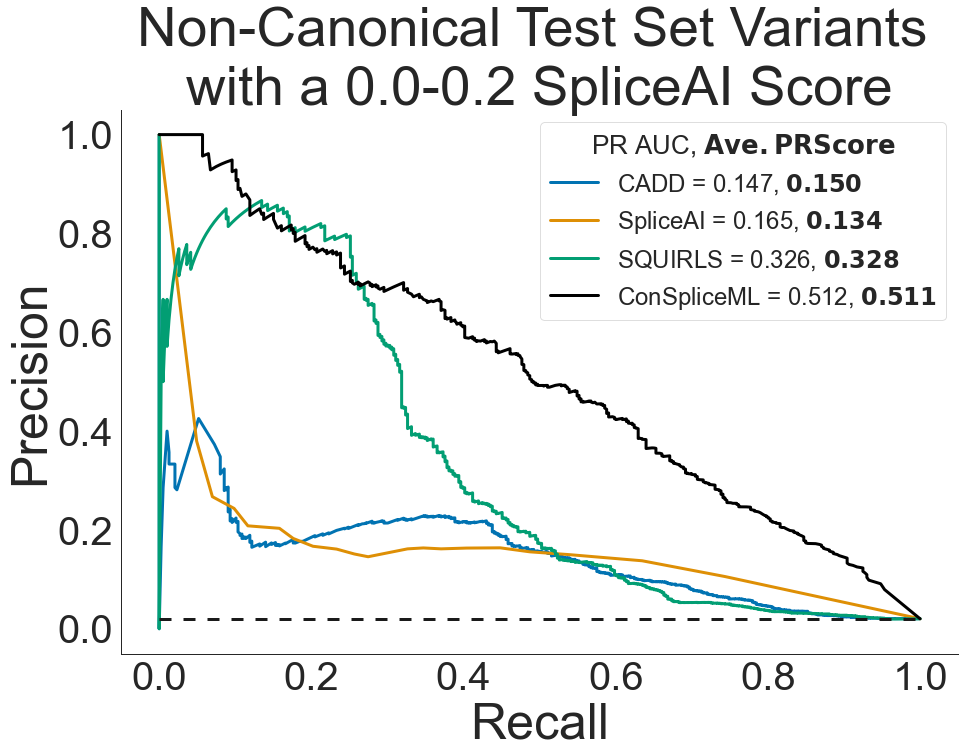

In [51]:
PR_LIST = []

pr_index = 0
for score, info in score_dict.items():

    (per,
     rec, 
     pr_thr, 
     pr_auc, 
     av_pr_score) = get_pr_vars(non_canonical_test_df,"patho_label",info["col"])
    
    PR_LIST.append({"per_list":per, 
                    "rec_list":rec,
                    "pr_auc":pr_auc,
                    "av_pr_score":av_pr_score, 
                    "line_label":info["label"], 
                    "line_color" : info["color"]})
    
    pr_index += 1

    
## y = P / (P + N)
y_base_line = (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
              / 
              (non_canonical_test_df[non_canonical_test_df.patho_label == 1].shape[0] 
               + 
               non_canonical_test_df[non_canonical_test_df.patho_label == 0].shape[0] 
              )
             )

base_line = {"x": [0,1], "y":[y_base_line,y_base_line]}

plot_title = "Non-Canonical Test Set Variants \nwith a 0.0-0.2 SpliceAI Score"
plot_combined_pr_curve(PR_LIST, base_line = base_line, plot_title = plot_title, legend_loc = "upper right")

plot_combined_pr_curve(PR_LIST, 
                       base_line = base_line, 
                       plot_title = plot_title, 
                       legend_loc = "lower left",
                       save_plot = True, 
                       output_name = '../figures/figure5_D.svg')


   Enrichment     bins        se    ci_lower    ci_upper
0    0.015373  0.0-0.1  0.121537    0.012115    0.019508
1    5.527517  0.1-0.2  0.175798    3.916409    7.801391
2   11.019117  0.2-0.3  0.194821    7.521620   16.142923
3   16.768184  0.3-0.4  0.218354   10.929990   25.724816
4   28.717625  0.4-0.5  0.231654   18.237301   45.220617
5   32.750658  0.5-0.6  0.281340   18.868568   56.846160
6   76.042156  0.6-0.7  0.279443   43.973206  131.498475
7   61.534769  0.7-0.8  0.303989   33.912541  111.655678
8  100.252781  0.8-0.9  0.308575   54.756035  183.552737
9  340.089574  0.9-1.0  0.397277  156.107658  740.904832


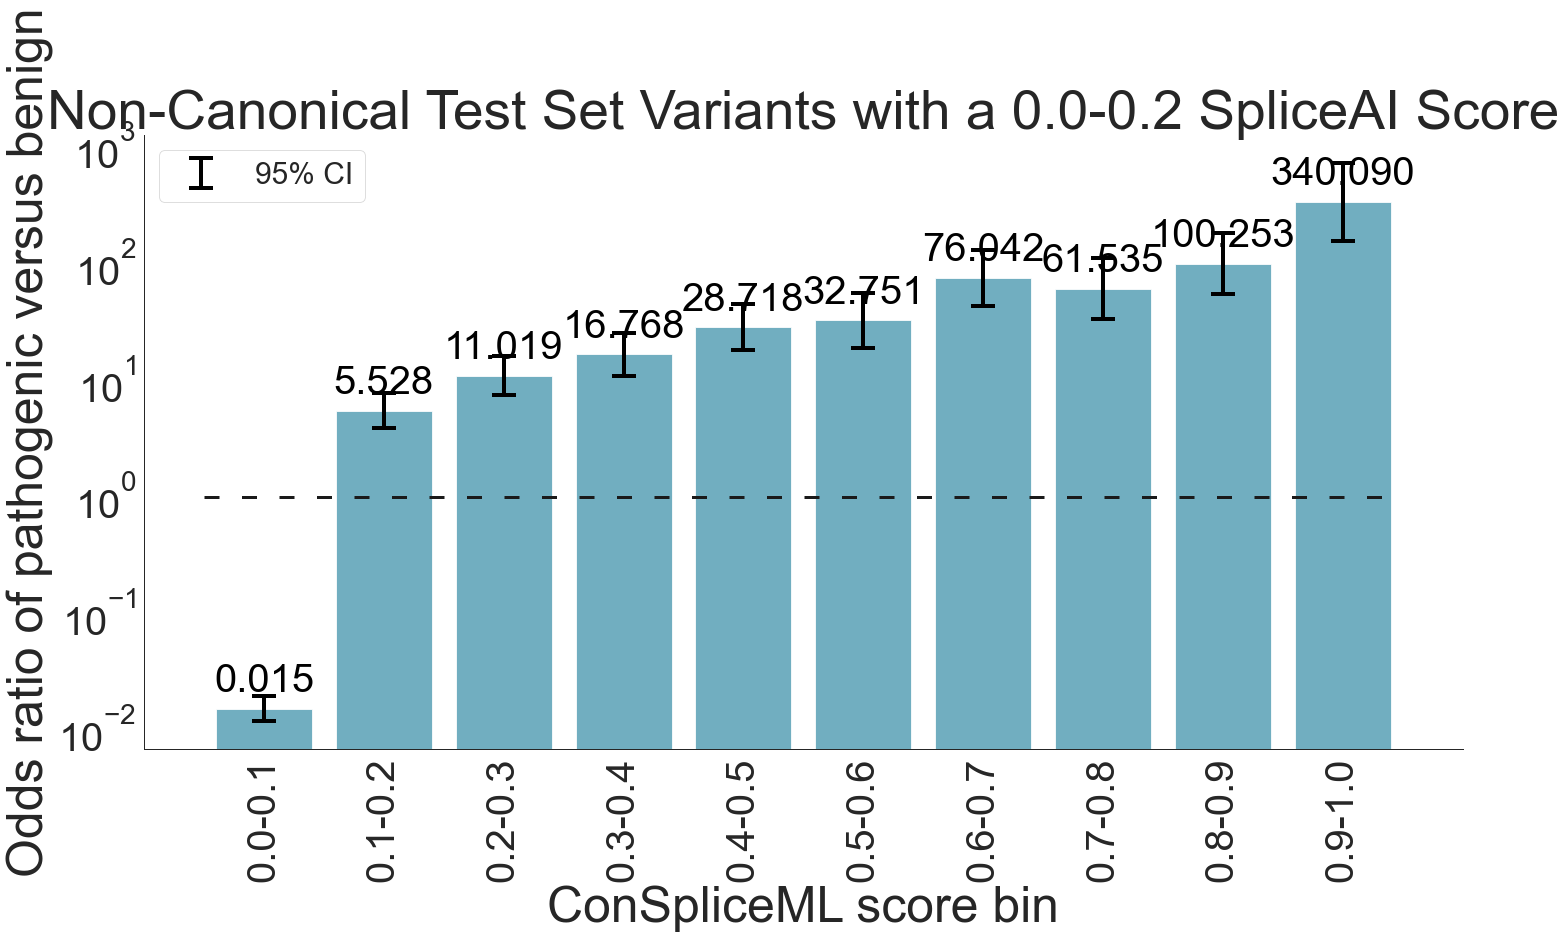

In [52]:
enrichment_df = enrichment_by_bin(non_canonical_test_df, "ConSpliceML", "patho_label")
print(enrichment_df)
plot_conspliceml_enrichment(enrich_df = enrichment_df,
                            score_col = "Enrichment",
                            bin_col = "bins",
                            ci_lower_bound_col = "ci_lower",
                            ci_upper_bound_col = "ci_upper",
                            title = "Non-Canonical Test Set Variants with a 0.0-0.2 SpliceAI Score",
                            plot_value_offset = 2.5)

plt.savefig('../figures/suppl_figure15_D.svg')

In [53]:
print("TEST: Number of pathogenic variants = {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 1].shape[0]))
print("TEST: Number of benign variants =     {}".format(non_canonical_test_df.loc[non_canonical_test_df.patho_label == 0].shape[0]))

TEST: Number of pathogenic variants = 386
TEST: Number of benign variants =     18684
